In [1]:
from qualibrate import QualibrationNode
from quam_libs.macros import T1_extraction
import numpy as np
import matplotlib.pyplot as plt


2026-02-20 01:09:57,734 - qm - INFO     - Starting session: e7ebdbc2-8b8b-489a-aabe-dc95b499e5c2


In [2]:
node  = QualibrationNode(name="quantum_memory_dephasing")

2026-02-20 01:10:09,972 - qualibrate - INFO - Creating node quantum_memory_dephasing


In [3]:
# plotting data structure

dephasing_T2_data = {
    'raw':{
        't2':[],
        't1':[],
        'dephasing_rate':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'mle':{
        't2':[],
        't1':[],
        'dephasing_rate':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'simulation_t2':{
        't2':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'simulation_t2_detuning':{
    't2':[],
    'axes':{'original':[], 'fit':[]},
    'volume':{'original':[], 'fit':[]},
    'negativity':{'original':[], 'fit':[]},
    }
}

In [4]:
from pathlib import Path
data_path = Path('/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/data/Markovian')


In [5]:
# T1 and T2 data

T1_mean, T1_std, T2_mean, T2_std = [], [], [], []
T1_experiment_index = [1274,1283,1292,1301,1310,1319,1328,1337,1346,1355,1364,1381,1390,1399,1409,1418,1427,1445,1436,1454,1466]
T2_experiment_index = [1276,1285,1294,1303,1312,1321,1330,1339,1348,1357,1366,1383,1392,1401,1411,1420,1429,1447,1438,1456,1467]

for T1_index, T2_index in zip(T1_experiment_index, T2_experiment_index):
    node_T1_ds = node.load_from_id(T1_index, base_path=data_path).results['ds']
    mean, std = T1_extraction(node_T1_ds)
    T1_mean.append(mean)
    T1_std.append(std)
    
    node_T2 = node.load_from_id(T2_index, base_path=data_path)
    T2_mean.append(node_T2.results['fit_results']['q0']['decay'])
    T2_std.append(node_T2.results['fit_results']['q0']['decay_error'])


In [6]:
# ellipsoid data 
dephasing_experiment_index = [1497,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1516,1515,1517,1518]
dephasing_voltage = [0,5,10,20,30,40,50,60,70,75,80,85,90,95,100,105,110,115,120,125,130]

dephasing_ds ={
    f'dephasing_voltage={dephasing_voltage[i]}mV':node.load_from_id(dephasing_experiment_index[i],base_path = data_path).results['ds']
    for i in range(len(dephasing_voltage))
}
dephasing_key = dephasing_ds.keys()

# dephasing vs flux amp

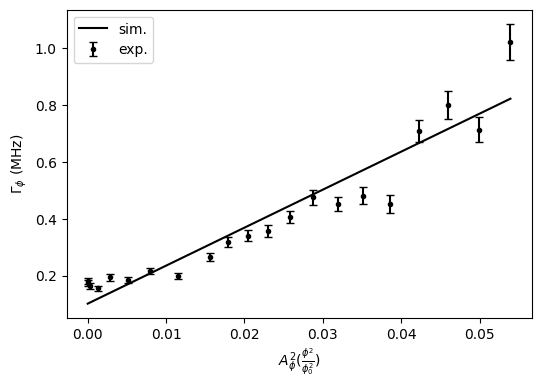

In [7]:
from quam_libs.macros import dephasing_errorbar
from scipy.optimize import curve_fit

gamma_phi,gamma_phi_std = dephasing_errorbar(np.array(T1_mean).reshape(-1),np.array(T2_mean),np.array(T1_std).reshape(-1),np.array(T2_std),pure=True)

fig = plt.figure(figsize=(6, 4))

phi_0 = 0.55978
xx = (np.array(dephasing_voltage)*1e-3/phi_0 )**2
a = -47701117184.95155

def fit_function(x,A):
    return (-0.5*phi_0*a*x*1e-3)*1e-6 +A

pop,povt = curve_fit(fit_function, xx, gamma_phi*1e-6, p0=[gamma_phi[0]])

plt.errorbar(xx, gamma_phi*1e-6, yerr=gamma_phi_std*1e-6, capsize=3,color='k',fmt='.', label='exp.')
#plt.plot(xx,(-0.5*phi_0*a*xx*1e-3+gamma_phi[0])*1e-6, label='sim.')
plt.plot(xx,fit_function(xx,pop[0]),color='k', label='sim.')

plt.xlabel(r'$A_\phi^2(\frac{\phi^2}{\phi_0^2})$')
plt.ylabel(r'$\Gamma_{\phi}$ (MHz)')
plt.legend()
plt.show()

# channel ellipsoid in dephasing noise

## experiment data

In [8]:
from quam_libs.QI_utils import bloch_vector_to_density_matrix
from quam_libs.analyzer import QuantumMemoryAnalyze, EllipsoidFitParameters

fit_params = EllipsoidFitParameters(
    filter_method="convex",      # "none" | "convex" | "ransac"
    correct_rotation_orientation =True,
    find_best_order=False
)

In [9]:
dephasing_data = {}
dephasing_analyze={}
do_convex_hull = True
for i, key in enumerate(dephasing_key):
    ds = dephasing_ds[key]
    data_xyz = np.array([[ds.Bloch_vector_x.values[0][i], ds.Bloch_vector_y.values[0][i], ds.Bloch_vector_z.values[0][i]] for i in range(len(ds.n_points.values))])
    data_angle = np.array([[ds.theta.values[i], ds.phi.values[i]] for i in range(len(ds.n_points.values))])
    data_dm = np.array([bloch_vector_to_density_matrix(data_xyz[i]) for i in range(len(data_xyz))])

    noise_analyzer = QuantumMemoryAnalyze(data_xyz,data_angle,fit_params)
    corrected_dm = noise_analyzer.corrected_dm
    corrected_bloch = noise_analyzer.corrected_bloch
    ellipsoid_results = noise_analyzer.ellipsoid_fit_results()
    dephasing_data[key] = {
        "qubit_properties":{
            "t1":T1_mean[i],
            "t1_std":T1_std[i],
            "t2":T2_mean[i],
            "t2_std":T2_std[i],
            "dephasing_rate":1/T2_mean[i] - 1/(2*T1_mean[i]),
        },
        'data':{
            'original_xyz': data_xyz,
            'original_dm' :data_dm,
            'angle': data_angle,
            'corrected_xyz': corrected_bloch,
            'corrected_dm': corrected_dm
        },
        'ellipsoid':{
            'axes':ellipsoid_results['axes'],
            'center':ellipsoid_results['center'],
            'volume':ellipsoid_results['volume'],
            'param':ellipsoid_results['fit_param'],
            "rotation_matrix":ellipsoid_results['rotation_matrix'],
        },
        "quantum_information":{
            "choi":noise_analyzer.choi,
            "robustness":noise_analyzer.memory_robustness
        }
    }
    dephasing_analyze[key] = noise_analyzer

/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/.venv/lib/python3.12/site-packages/pennylane/__init__.py:212: PennyLaneDeprecationWarning: PennyLane v0.44 has dropped maintainence support for NumPy < 2.0.0. You have version 1.26.4 installed. Future versions of PennyLane will not work with NumPy<2.0. Please consider upgrading NumPy using `python -m pip install numpy --upgrade`. 
  warnings.warn(
/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/.venv/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)
/Users/jackchao/Desktop/Proje

After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is valid.


In [10]:
robust  = [dephasing_data[key]['quantum_information']['robustness'] for key in dephasing_data.keys()]
T2 = [dephasing_data[key]['qubit_properties']['t2'] for key in dephasing_data.keys()]

In [11]:
for key in dephasing_data.keys():
    print(f"{key}, T2 = {dephasing_data[key]['qubit_properties']['t2']}, dephasing rate = {dephasing_data[key]['qubit_properties']['dephasing_rate']}")
    print(f"determinant = {np.linalg.det(dephasing_data[key]['ellipsoid']['rotation_matrix'])}")
    print(f"rotation matrxis = \n{dephasing_data[key]['ellipsoid']['rotation_matrix']}")
    print(f"axes = {dephasing_data[key]['ellipsoid']['axes']}")
    print(f"volume = {dephasing_data[key]['ellipsoid']['volume']}, robustness = {dephasing_data[key]['quantum_information']['robustness']}\n")
    

dephasing_voltage=0mV, T2 = 5.777260776577812e-06, dephasing rate = [173092.37377824]
determinant = -1.0
rotation matrxis = 
[[-0.71364824 -0.69546208 -0.08389684]
 [-0.69050793  0.67824002  0.25137478]
 [ 0.11791943 -0.2373246   0.96424688]]
axes = [0.72316099 0.68095996 0.77711545]
volume = 1.6029896414681508, robustness = 0.5645719691392288

dephasing_voltage=5mV, T2 = 5.521741138548081e-06, dephasing rate = [181102.25949249]
determinant = -1.0
rotation matrxis = 
[[-0.72664888 -0.6868923   0.01266354]
 [-0.67623753  0.71838565  0.16317124]
 [ 0.12117838 -0.11000464  0.98651649]]
axes = [0.746858   0.69532477 0.81914172]
volume = 1.7818592262424904, robustness = 0.6223920852482512

dephasing_voltage=10mV, T2 = 6.122530721714111e-06, dephasing rate = [163331.11400872]
determinant = -0.9999999999999998
rotation matrxis = 
[[ 0.66748128  0.74060149  0.07731865]
 [ 0.71924823 -0.61436946 -0.32439506]
 [ 0.19274525 -0.27213893  0.94275642]]
axes = [0.76177922 0.71275374 0.80379333]
volum

In [12]:
x_list = [dephasing_data[key]['qubit_properties']['dephasing_rate'] for key in dephasing_data.keys()]
#x_list = [dephasing_data[key]['qubit_properties']['T2'] for key in dephasing_data.keys()]

axes_list = [dephasing_data[key]['ellipsoid']['axes'] for key in dephasing_data.keys()]
volume_list = [dephasing_data[key]['ellipsoid']['volume'] for key in dephasing_data.keys()]
robust_list = [dephasing_data[key]['quantum_information']['robustness'] for key in dephasing_data.keys()]

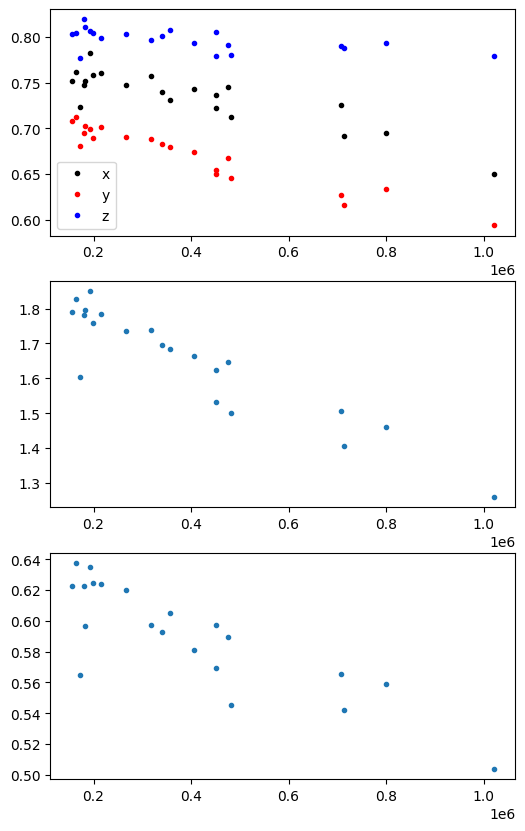

In [13]:
fig = plt.figure(figsize=(6,10))
ax_axes = fig.add_subplot(311)
ax_volume = fig.add_subplot(312)
ax_robustness = fig.add_subplot(313)
ax_axes.plot(x_list, [axes[0] for axes in axes_list], '.k',label='x')
ax_axes.plot(x_list, [axes[1] for axes in axes_list], '.r',label='y')
ax_axes.plot(x_list, [axes[2] for axes in axes_list], '.b',label='z')
ax_axes.legend()

ax_volume.plot(x_list, volume_list, '.')
ax_robustness.plot(x_list, robust_list, '.')
# ax_robustness.plot(x_list,find_best_order_list,'.')
# ax_robustness.set_xlim(0.1e6,0.4e6)

## simulation data